<a href="https://colab.research.google.com/github/KORALLLL/summer_practice/blob/main/bagging/8net4bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eighth FC NN for bagging

## Configuration

датасет: MNIST[42000:48000]

размер обучающей выборки: 6000(сырого) + 14000(аугментаций)

размер тестирующей выборки: 10000

количество скрытых слоёв: 3

количество нейронов в скрытых слояx: 300

функция активации: сигмоида

функция потерь: кросс энтропия

оптимизатор: Adam

скорость обучение: 0.001

размер батча: 2000

количество эпох: 700

## Prepairing data

In [9]:
start = 42000
stop = 48000

import torch
import torchvision.datasets
import torchvision.transforms
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from copy import deepcopy

def augmentation(old_image, label):
  old_image = Image.fromarray(old_image.numpy(), mode='L')

  rotater = torchvision.transforms.RandomRotation(degrees = (-15, 15))
  h_flipper = torchvision.transforms.RandomHorizontalFlip(p=1) #only for 08
  v_flipper = torchvision.transforms.RandomVerticalFlip(p=1) #only for 08
  shifter = torchvision.transforms.RandomAffine(0, translate = (2/28,2/28))
  compressor = torchvision.transforms.RandomAffine(0, scale = (0.8, 0.9))
  stratcher = torchvision.transforms.RandomAffine(0, scale = (1.05, 1.1))

  seed1 = random.randint(0, 3)
  if label == 0 or label == 8:
    if seed1 == 0:
      image = old_image
    elif seed1 == 1:
      image = h_flipper(old_image)
    elif seed1 == 2:
      image = v_flipper(old_image)
    else:
      image = h_flipper(v_flipper(old_image))
  else:
    image = old_image

  seed = random.randint(0,10)
  if seed == 0: #rot
    new_image = rotater(image)
  elif seed == 1: #shift
    new_image = shifter(image)
  elif seed == 2: #comp
    new_image = compressor(image)
  elif seed == 3: #str
    new_image = stratcher(image)
  elif seed == 4: #rot+shift
    new_image = rotater(shifter(image))
  elif seed == 5: #rot+comp
    new_image = rotater(compressor(image))
  elif seed == 6: #rot+str
    new_image = rotater(stratcher(image))
  elif seed == 7: #shift+comp
    new_image = shifter(compressor(image))
  elif seed == 8: #shift+stretch
    new_image = shifter(stratcher(image))
  elif seed == 9: #rot+shift+comp
    new_image = rotater(shifter(compressor(image)))
  elif seed == 10: #tor+shift+stretch
    new_image = rotater(shifter(stratcher(image)))

  new_image = torchvision.transforms.ToTensor()(new_image)
  new_image = new_image.squeeze()
  return(new_image)


MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

x_train = MNIST_train.data[start:stop]
y_train = MNIST_train.targets[start:stop]

temp_x_train, temp_train_label = [], []
random_indexes = random.choices(range(0,6000), k=14000)

for i in random_indexes:
  image, label = x_train[i], y_train[i]
  new_image = augmentation(image, label)
  temp_x_train.append(new_image)
  temp_train_label.append(label)

temp_x_train = torch.stack(temp_x_train)
temp_train_label = torch.stack(temp_train_label)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

x_train = torch.cat([x_train, temp_x_train], dim = 0).float().reshape([-1,28*28]).to(device)
y_train = torch.cat([y_train, temp_train_label], dim = 0).to(device)
x_test = MNIST_test.data.float().reshape([-1, 28*28]).to(device)
y_test = MNIST_test.targets.to(device)


## Configuration net

In [10]:
class MNISTNet(torch.nn.Module):
  def __init__(self):
    super(MNISTNet, self).__init__()
    self.fc1 = torch.nn.Linear(28*28, 300)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(300,300)
    self.act2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(300, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

## Hyperparameters

In [11]:
loss = torch.nn.CrossEntropyLoss()
batch_size = 2000

## Test learning on 5000 epoch

In [12]:
net = MNISTNet().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

train_acc, test_acc = [], []
train_loss, test_loss  = [], []

for epoch in tqdm(range(5000), desc = 'обучение'):
  order = np.random.permutation(len(x_train))

  for start_index in range(0, len(x_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    x_train_batch = x_train[batch_indexes]
    y_train_batch = y_train[batch_indexes]

    pred = net.forward(x_train_batch)

    loss_val = loss(pred, y_train_batch)
    loss_val.backward()

    optimizer.step()

  train_preds = net.forward(x_train)
  test_preds = net.forward(x_test)

  train_acc.append((train_preds.argmax(dim=1) == y_train).float().mean().cpu().data)
  test_acc.append((test_preds.argmax(dim=1) == y_test).float().mean().cpu().data)

  train_loss.append(loss(train_preds, y_train).item())
  test_loss.append(loss(test_preds, y_test).item())

<ipython-input-12-014e0bf3f1f9>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(5000), desc = 'обучение'):


обучение:   0%|          | 0/5000 [00:00<?, ?it/s]

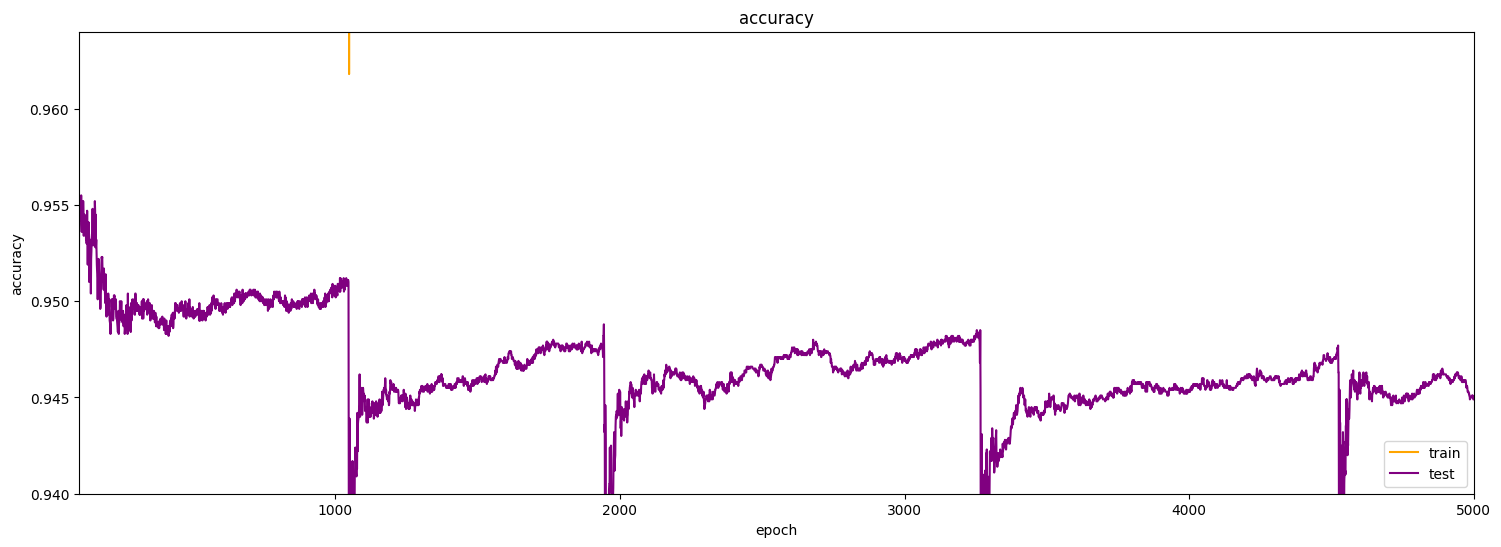

In [15]:
plt.figure(figsize = (18.0, 6.0))
plt.plot(range(5000), train_acc, c='orange', label = 'train')
plt.plot(range(5000), test_acc, c = 'purple', label = 'test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(100, 5000)
plt.ylim(0.94, 0.964)
plt.title('accuracy')
plt.legend(loc = 'lower right')

Text(0, 0.5, 'loss')

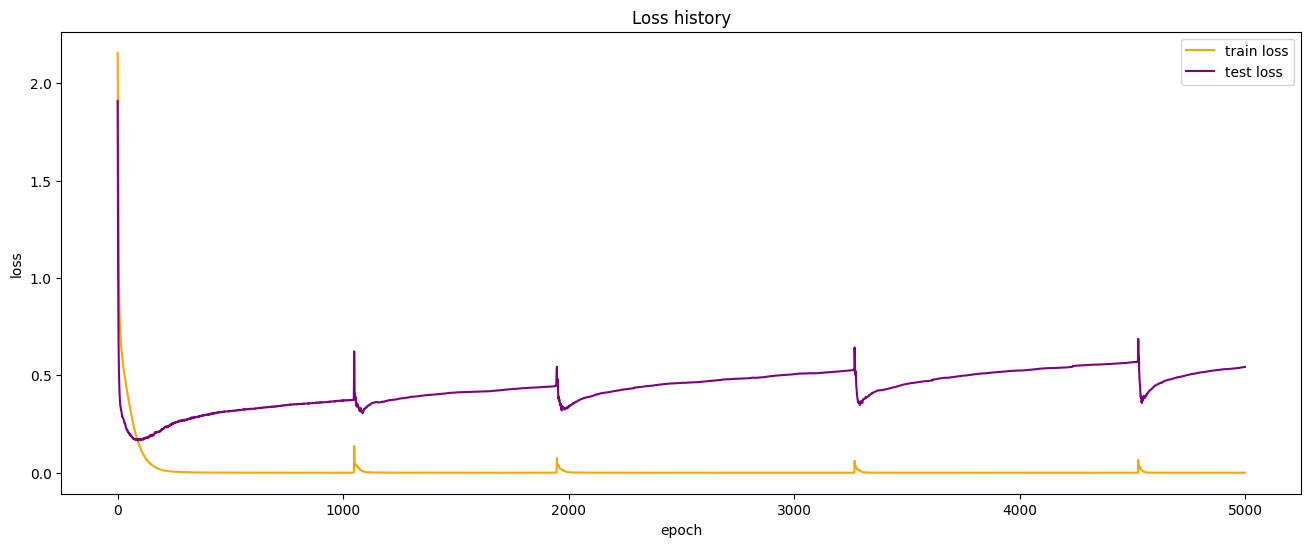

In [16]:
plt.figure(figsize = (16.0, 6.0))
plt.plot(range(5000), train_loss, c='orange', label = 'train loss')
plt.plot(range(5000), test_loss, c = 'purple', label = 'test loss')
plt.title('Loss history')
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

## Learning model

In [17]:
best_acc = 0.0
best_state = None

for experiment in tqdm(range(200), desc = 'Эксперимент'):
  net = MNISTNet().to(device)
  optimizer = torch.optim.RMSprop(net.parameters(), lr = 0.001)

  for epoch in tqdm(range(200), desc = 'Обучение'):
    order = np.random.permutation(len(x_train))

    for start_index in range(0, len(x_train), batch_size):
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]

      x_train_batch = x_train[batch_indexes]
      y_train_batch = y_train[batch_indexes]

      pred = net.forward(x_train_batch)

      loss_val = loss(pred, y_train_batch)
      loss_val.backward()

      optimizer.step()

  test_preds = net.forward(x_test)

  cur_acc = ((test_preds.argmax(dim=1) == y_test).float().mean().cpu().data)
  print(cur_acc)

  if cur_acc > best_acc:
    best_acc = cur_acc
    best_state = deepcopy(net.state_dict())

<ipython-input-17-e0aa522ef917>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in tqdm(range(200), desc = 'Эксперимент'):


Эксперимент:   0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-17-e0aa522ef917>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(200), desc = 'Обучение'):


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9597)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9589)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9572)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9600)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9561)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9573)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9579)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9560)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9576)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9571)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9579)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9580)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9577)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9576)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9572)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9566)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9573)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9572)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9558)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9578)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9550)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9559)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9566)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9565)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9561)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9577)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9559)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9596)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9569)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9566)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9550)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9578)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9544)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9553)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9559)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9566)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9576)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9579)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9558)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9589)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9564)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9578)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9588)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9564)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9587)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9553)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9559)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9573)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9559)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9585)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9590)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9565)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9543)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9590)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9598)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9550)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9582)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9611)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9578)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9595)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9567)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9586)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9592)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9558)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9585)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9591)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9547)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9557)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9581)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9558)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9624)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9563)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9588)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9602)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9506)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9587)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9557)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9580)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9585)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9587)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9589)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9590)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9538)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9537)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9580)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9577)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9543)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9553)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9581)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9585)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9532)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9554)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9552)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9528)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9588)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9593)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9112)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9582)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9140)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9595)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9343)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9564)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9581)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9571)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9578)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9544)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9581)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9555)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9543)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9590)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9573)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9582)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9571)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9590)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9573)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9566)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9563)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9557)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9594)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9559)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9579)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9572)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9591)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9586)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9567)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9574)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9560)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9520)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9595)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9557)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9573)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9584)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9576)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9557)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9585)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9560)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9565)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9595)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9567)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9565)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9570)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9564)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9562)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9571)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9560)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9604)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9609)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9542)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9580)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9583)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9567)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9595)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9532)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9595)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9599)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9582)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9588)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9575)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9560)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9580)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9555)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9563)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9566)


Обучение:   0%|          | 0/200 [00:00<?, ?it/s]

tensor(0.9584)


In [18]:
torch.save(best_state, 'parameters_8net4bagging.pth')
net = MNISTNet().to(device)
net.load_state_dict(torch.load('parameters_8net4bagging.pth'))
test_preds = net.forward(x_test)
print(((test_preds.argmax(dim=1) == y_test).float().mean().cpu().data))

tensor(0.9624)
